In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv("SpotifyFeatures.csv")
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228159 entries, 0 to 228158
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             228159 non-null  object 
 1   artist_name       228159 non-null  object 
 2   track_name        228159 non-null  object 
 3   track_id          228159 non-null  object 
 4   popularity        228159 non-null  int64  
 5   acousticness      228159 non-null  float64
 6   danceability      228159 non-null  float64
 7   duration_ms       228159 non-null  int64  
 8   energy            228159 non-null  float64
 9   instrumentalness  228159 non-null  float64
 10  key               228159 non-null  object 
 11  liveness          228159 non-null  float64
 12  loudness          228159 non-null  float64
 13  mode              228159 non-null  object 
 14  speechiness       228159 non-null  float64
 15  tempo             228159 non-null  float64
 16  time_signature    22

In [3]:
# Tidying data for normalization
data = data.drop(["track_id","key","mode","time_signature"],1)
df = data.copy()

# what we are trying to predict (our y)
df = df.drop(["artist_name","track_name"],1)

# our predictors/categories/classes 
col = ['popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence']

# Normalizing the categories - col variable ^^^

# z score
# The standard score of a sample x is calculated as:
#     z = (x - u) / s
# how far our training set/prediction is from the mean (standard deviations away)
# 'Template like' z score transformation
scaler = StandardScaler()
df[col] = scaler.fit_transform(df[col])

# One Hot Encoding for each category
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

# Predicting the categories based on genre
enc = pd.DataFrame(encoder.fit_transform(np.array(df["genre"]).reshape(-1,1)))
enc.columns = df["genre"].unique()

# were able to create predictions related to how far each individual prediction is from our mean/original training set (std away)
df[enc.columns] = enc
df = df.drop("genre",1)

# re-inializing the tranformed data set (one hot endcoded) to include original name and artists for song prediction
df["name"] = data["track_name"]
df["artist"] = data["artist_name"]

# df_2 only has the clategories we utilized with one hot encoding
df_2 = df.drop(["artist","name"],1)

In [4]:
original_index = 0
def sim_track_find(word,artist):
    global original_index
    a = 0
    b = 0
    song = []
    indexes = []
    original_index = 0
    for i in data["track_name"]:
        if word.lower() in i.lower() and artist.lower() in data["artist_name"][a].lower():
            song.append(df_2[a:a+1].values)
            indexes.append(a)
            original_index = i
            b+=1
        a+=1
    if b == 0:
        print("Nothing found. Please try something else :)")
        return 0
        
    return song[0][0], indexes[0]

X_cosine = []
Y_cosine = []
def similar_tracks_cosine(number,song = "",artist = ""):

    if (sim_track_find(song,artist) == 0):
        return 0
    else:
        # our x values = features ( y = x * w)
        x=sim_track_find(song,artist)[0]
        
        # index of the row where the song exists in data = 12802
        index = sim_track_find(song,artist)[1]
    p = []
    count=0
    for i in df_2.values:
        # find the cosine distance between each training set (x values) and the features/weights
        # cosine euclidean jaccard
        p.append([distance.cosine(x,i),count])
        count+=1
    # smallest to largest distances
    p.sort()
    song_names = df["name"]
    artist_names = df["artist"]
    print("\nSimilar songs to ",song_names[index]," by ", artist_names[index],"\n")
    songs = []
    artists = []
    for i in range(1,number+1):
        print("Statistical Score: ", p[i][1])
        print("Feature Sets: ", p[i][0])
        
        X_cosine.append(p[i][0])
        Y_cosine.append(p[i][1])
        songs.append(song_names[p[i][1]])
        artists.append(artist_names[p[i][1]])
        print(i,"- ",song_names[p[i][1]],", ",artist_names[p[i][1]])
    data = np.array([Y_cosine, songs, artists])
    table = pd.DataFrame(data)
    print(table)


Similar songs to  ocean eyes  by  Billie Eilish 

Statistical Score:  33596
Feature Sets:  0.02443736477285341
1 -  Abrázame Muy Fuerte ,  Juan Gabriel
Statistical Score:  13821
Feature Sets:  0.027182517475585977
2 -  I Can't Fall in Love Without You ,  Zara Larsson
Statistical Score:  12746
Feature Sets:  0.03537442323285356
3 -  idontwannabeyouanymore ,  Billie Eilish
Statistical Score:  13751
Feature Sets:  0.038868824735028285
4 -  Make It To Me ,  Sam Smith
Statistical Score:  13004
Feature Sets:  0.04195038558681041
5 -  Let It Go ,  James Bay
                     0                                 1  \
0                33596                             13821   
1  Abrázame Muy Fuerte  I Can't Fall in Love Without You   
2         Juan Gabriel                      Zara Larsson   

                        2              3          4  
0                   12746          13751      13004  
1  idontwannabeyouanymore  Make It To Me  Let It Go  
2           Billie Eilish      Sam Smit

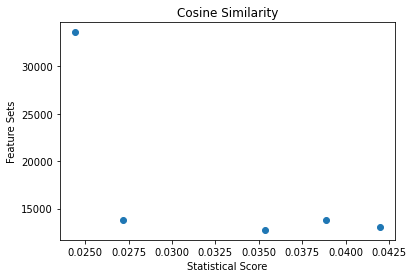

In [5]:
import matplotlib.pyplot as plt
import numpy as np

song = "ocean eyes"
artist = "billie"
num = 5

similar_tracks_cosine(num,song,artist)
x = X_cosine
y = Y_cosine
# print(X_cosine)
print(original_index)
plt.scatter(x, y)
plt.title("Cosine Similarity")
plt.xlabel("Statistical Score")
plt.ylabel("Feature Sets")
plt.show()

In [ ]:
from IPython.display import Audio 
from IPython.core.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa

cosine_songs = [
    "Juan Gabriel - Abrazame Muy Fuerte Letra.wav",
    "Zara Larsson _ I Can't Fall In Love Without You _ Lyrics.wav",
    "Billie Eilish - idontwannabeyouanymore (Lyrics).wav"
]
euclidean_songs = [
    "Zara Larsson _ I Can't Fall In Love Without You _ Lyrics.wav",
    "Billie Eilish - idontwannabeyouanymore (Lyrics).wav",
    "Let It Go - James Bay (Lyrics).wav" 
]
jaccard_songs = [
    "goosebumps.wav",
    "Young Dumb & Broke _ Khalid _ Lyrics.wav",
    "Khalid, Normani - Love Lies (Lyrics).wav"
]

options = ["Jaccard", "Euclidean", "Cosine"]

print("\nSimilar songs to Ocean Eyes by Billie Eilish\n")
display(Audio('songs/' + 'Billie Eilish - Ocean Eyes (Lyrics).wav'))

for i in range(len(options)):
    if options[i] == "Jaccard":
        print("Jaccard Distance")
        for j in range(len(jaccard_songs)):
            print(jaccard_songs[j])
            display(Audio('songs/' + jaccard_songs[j]))
        print()
    elif options[i] == "Euclidean":
        print("Euclidean Distance")
        for j in range(len(euclidean_songs)):
            print(euclidean_songs[j])
            display(Audio('songs/' + euclidean_songs[j]))
        print()
    elif options[i] == "Cosine":
        print("Cosine Similarity")
        for j in range(len(cosine_songs)):
            print(cosine_songs[j])
            display(Audio('songs/' + cosine_songs[j]))
        print()


Similar songs to Ocean Eyes by Billie Eilish



In [ ]:
song1 = 'songs/Billie Eilish - Ocean Eyes (Lyrics).wav'
x, sr = librosa.load(song1)
plt.figure(figsize=(14, 5))
# librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [ ]:
from math import sqrt
# A dictionary of movie critics and their ratings of a small
# set of movies

# time played

arr = similar_songs()

users = {
    "user1" : {
        arr[0] : 34,
        1235 : 1,
        1236 : 22
    },
    "user2" : {
        arr[0] : 34,
        1235 : 12,
        1236 : 89
    }
}

critics={
    'user': {
        'Lady in the Water': 5,
        'Snakes on a Plane': 4,
        'Just My Luck': 3,
        'Superman Returns': 4,
        'You, Me and Dupree': 3.9,
        'The Night Listener': 4.1
    },
    'Lisa Rose': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'Superman Returns': 3.5,
        'You, Me and Dupree': 2.5,
        'The Night Listener': 3.0
    },
    'Gene Seymour': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 1.5,
        'Superman Returns': 5.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 3.5
    },
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0,
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0},
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs, person1, person2):
    si = {}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item] = 1

    if len(si)==0: return 0
    sum_of_squares = sum([pow(prefs[person1][item] - prefs[person2][item], 2) for item in si])

    return 1/(1+sqrt(sum_of_squares))

def sim_pearson(prefs,p1,p2):
  # Get the list of mutually rated items
  si={}
  for item in prefs[p1]:
    if item in prefs[p2]: si[item]=1

  # Find the number of elements
  n=len(si)

  # if they have no ratings in common, return 0
  if n==0: return 0

  # Add up all the preferences
  sum1=sum([prefs[p1][it] for it in si])
  sum2=sum([prefs[p2][it] for it in si])

  # Sum up the squares
  sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
  sum2Sq=sum([pow(prefs[p2][it],2) for it in si])

  # Sum up the products
  pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])

  # Calculate Pearson score
  num=pSum-(sum1*sum2/n)
  den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
  if den==0: return 0
  r=num/den

  return r

val = sim_distance(critics, 'Lisa Rose', 'Gene Seymour')
print(val)

val1 = sim_pearson(critics, 'Lisa Rose', 'Gene Seymour')
print(val1)

# Returns the best matches for person from the prefs dictionary.
# Number of results and similarity function are optional params.
def topMatches(prefs,person,n=5,similarity=sim_pearson):
  scores=[(similarity(prefs,person,other),other)
                  for other in prefs if other!=person]

  # Sort the list so the highest scores appear at the top
  scores.sort(  )
  scores.reverse(  )
  return scores[0:n]

val2 = topMatches(critics, 'user', n=3)
print(val2)

In [5]:
import random
def sim_track(number,song = "",artist = ""):

    if (sim_track_find(song,artist) == 0):
        return 0
    else:
        # our x values = features ( y = x * w)
        x=sim_track_find(song,artist)[0]

        # index of the row where the song exists in data = 12802
        index = sim_track_find(song,artist)[1]
    p = []
    count=0
    for i in df_2.values:
        p.append([distance.cosine(x,i),count])
        count+=1
    p.sort()
    temp = {}
    for i in range(1,number+1):
        temp[p[i][1]] = p[i][0]
    return temp

def sim_pearson(prefs,p1,p2):
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1
    n=len(si)
    if n==0: return 0
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0
    r=num/den

    return r

def create_user(num):
    song_index = []
    for i in range(num):
        r = random.randrange(0, len(data))
        song_index.append(r)
    return song_index

def create_songs_list(num):
    song_index = []
    for i in range(num):
        r = random.randrange(0, len(data))
        song_index.append(data[r:r+1]['track_name'].values[0])
    return song_index

def similarity_list(user_count, song_count):
    result = {}
    arr = create_user(user_count)
    counter = 1
    for i in arr:
        if len(data) != i:
            X_cosine.clear()
            result['user' + str(counter)] = sim_track(song_count,data[i:i+1]['track_name'].values[0],data[i:i+1]['artist_name'].values[0])
        counter+=1
    return result



def times_played_simulation(user_count, song_count):
    result = {}
    songs = create_songs_list(song_count)
    counter = 1
    for i in range(user_count):
        temp = {}
        for song in songs:
            temp[song] = random.randrange(0, 100)
        result['user' + str(counter)] = temp
        counter+=1
    return result


def liked_songs_simulation(user_count, song_count):
    result = {}
    songs = create_songs_list(song_count)
    counter = 1
    for i in range(user_count):
        temp = {}
        for song in songs:
            temp[song] = random.randrange(0, 2)
        result['user' + str(counter)] = temp
        counter+=1
    return result

def topMatches(prefs,person,n=5,similarity=sim_pearson):
    scores=[(similarity(prefs,person,other),other)
                for other in prefs if other!=person]

    # Sort the list so the highest scores appear at the top
    scores.sort()
    scores.reverse()
    return scores[0:n]

amt_of_users = 20
amt_of_songs = 10
top_users_count = 5
# liked songs    
users={
    'user1': {
        33596: 1,
        13821: 0,
        13004: 0,
        12746: 0,
    },
    'user2': {
        33596: 1,
        13821: 0,
        13004: 1,
        12746: 0,
    },
    'user3': {
        33596: 1,
        13821: 1,
        13004: 1,
        12746: 1,
    },
    'user4': {
        33596: 1,
        13821: 0,
        13004: 1,
        12746: 1,
    },
    'user5': {
        33596: 1,
        13821: 1,
        13004: 1,
        12746: 0,
    },
    'user6': {
        33596: 1,
        13821: 1,
        13004: 1,
        12746: 0,
    }
}
# number of times played    
users={
    'user1': {
        33596: 40,
        13821: 2,
        13004: 10,
        12746: 34,
    },
    'user2': {
        33596: 14,
        13821: 16,
        13004: 7,
        12746: 8,
    },
    'user3': {
        33596: 56,
        13821: 47,
        13004: 12,
        12746: 1,
    },
    'user4': {
        33596: 99,
        13821: 50,
        13004: 41,
        12746: 40,
    },
    'user5': {
        33596: 10,
        13821: 11,
        13004: 12,
        12746: 22,
    },
    'user6': {
        33596: 100,
        13821: 2,
        13004: 30,
        12746: 47,
    }
}
print("Times Played Simulation")
users = times_played_simulation(amt_of_users,amt_of_songs)
# print(users)
print(topMatches(users, 'user1', n=top_users_count))
print("\nLiked Songs Simulation")
users = liked_songs_simulation(amt_of_users,amt_of_songs)
print(topMatches(users, 'user1', n=top_users_count))
# future work
# merging the preferences: times played, liked songs, and genre
# clustering comparisons by genre, smaller sets of data to get accurate comparisions
# they liked these songs

Times Played Simulation


NameError: name 'random' is not defined